# Simple Neural Net Classifier

This notebook demonstrates using Tensorflow and Keras libraries to train a simple neural net classifier to make predictions using the CPUNKS-10k dataset. This notebook assumes familiarity with the Tensorflow, Keras and basic concepts in machine learning.

### Setup

Import and configure numpy, pandas, matplotlib, Tensorflow and Keras.

In [1]:
import numpy as np
import pandas as pd

from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

### Load CPUNKS-10K Dataset and Inspect it.

The function below implements a naive partitioning strategy for creating train and test sets built from CPUNKS-10K. It is included here so that you can extend it as you explore new partitioning strategies.

In [2]:
class cpunks10k:
    def __init__(self):
        self.punks_df = pd.read_pickle('../data/punks.pkl')
        self.labels = list(self.punks_df.dtypes[0:-1].index)
        
    def any_to_one(self, i):
        x= True
        if i['any']:
            x=False
        return int(x)

    def load_data(self, labels=None):
        if labels:
            self.labels=labels
        df = self.punks_df.copy()[labels + ['img']]
        df['any'] = df[labels].apply(np.any, axis=1)
        df['none'] = df.apply(lambda x: self.any_to_one(x), axis=1)
        df = df.drop(['any'], axis=1)
        X = df['img'].to_numpy()
        Y = df[labels + ['none']].to_numpy()
        X  = np.array([row[0] for row in X])
        X_train = X[0:9000]
        Y_train = Y[0:9000]
        X_test = X[9000:10000]
        Y_test = Y[9000:10000]
        self.labels = labels + ['none']
        return (X_train, Y_train), (X_test, Y_test)

Run the function to create train and test sets for use in Keras and Tensorflow. In this example, we will keep the classifier as simple as possible, using only 'male' and 'female' traits in classification.

In [3]:
cp = cpunks10k()

In [4]:
labels = ['male', 'female']
labels = ['alien', 'ape', 'zombie', 'male', 'female']
labels = ['earring']
labels = ['wildHair']
(X_train, Y_train),(X_test, Y_test) = cp.load_data(labels)
cp.labels

['wildHair', 'none']

Inspect the data.

In [5]:
(X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape)

(((9000, 24, 24, 3), (9000, 2)), ((1000, 24, 24, 3), (1000, 2)))

### Build a Simple Classifier.

Each of the images in CPUNKS-10K is comprised of a 24X24X3 `numpy` array holding uint8 values. The network shown below setups the `Input` layer based on image size, creates two `Dense` layers and a final output layer that will hold probabilities for each of the 2 labels in the output.

In [7]:
input_layer = Input(shape = (24, 24,3))
x = Flatten()(input_layer)

x = Dense(units = 200, activation = 'relu')(x)
x = Dense(units = 150, activation = 'relu')(x)

output_layer = Dense(units=len(cp.labels), activation = 'softmax')(x)

model = Model(input_layer, output_layer)

Next, create an optimizer with learning rate = 0.0005 and compile the model.

In [8]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics = ['accuracy'])

### Train the model

Use the model's `fit` method to train the model.

In [9]:
model.fit(X_train,
          Y_train,
          batch_size = 32,
          epochs = 10,
          shuffle = True)

2021-12-29 14:29:02.196322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-29 14:29:02.216527: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3192815000 Hz


Epoch 1/10
282/282 [==============================] - 2s 5ms/step - loss: 0.1097 - accuracy: 0.9670
Epoch 2/10
282/282 [==============================] - 1s 5ms/step - loss: 0.0065 - accuracy: 0.9992
Epoch 3/10
282/282 [==============================] - 1s 5ms/step - loss: 0.0040 - accuracy: 0.9983
Epoch 4/10
282/282 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.9999
Epoch 5/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0062 - accuracy: 0.9976
Epoch 6/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0024 - accuracy: 0.9991
Epoch 7/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 0.9992
Epoch 8/10
282/282 [==============================] - 2s 6ms/step - loss: 1.5109e-04 - accuracy: 1.0000
Epoch 9/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 0.9994
Epoch 10/10
282/282 [==============================] - 2s 6ms/step - loss: 8.3145e-04 - accuracy

### Evaluate the Model

The model's `evaluate` method will peek at the outsample test data to calculate an accuracy score for the trained model. 

In [10]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 0.9970


[0.007132469676434994, 0.996999979019165]

You will probably find that the model is strikingly accurate for such a simple model. Understanding why this model is so accurate is a great exercise for beginning machine learning practicioners and left as an exercise. 

### Trust and Validate

When a model returns surprising results, it is always good to validate using inspection methods. For humans, visual inpsection is a great first pass.

First, collect all the predictions on the outsample and prepare two arrays containing predicted v. actual

In [11]:
labels=np.array(cp.labels)

preds = model.predict(X_test)
preds_single = labels[np.argmax(preds, axis=-1)]
actual_single = labels[np.argmax(Y_test, axis=-1)]

Now, plot the predicted v. actual in a grid using `matplotlib`.

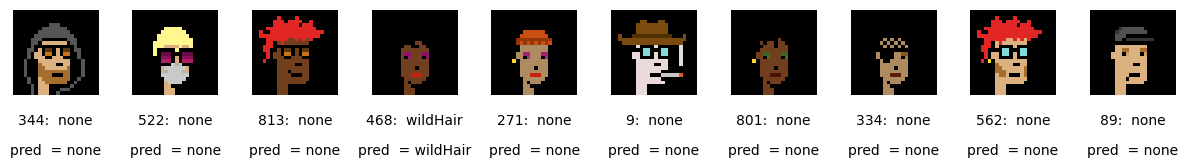

In [12]:
n=10
indices = np.random.choice(range(len(X_test)), n)
fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, idx in enumerate(indices):
    img = X_test[idx]
    ax = fig.add_subplot(1, n, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 
            f"{idx}:  {str(actual_single[idx])}", 
            fontsize=10, 
            ha='center',
            transform=ax.transAxes)
    ax.text(0.5, 
            -0.70, 
            'pred  = ' + str(preds_single[idx]), 
            fontsize=10,  
            ha='center',
           transform=ax.transAxes)
    ax.imshow(img)

# Inspect a single punk.

After random inspection, you might want to inspect the values for a single punk. For example, checking in on a zombie or alien.

The test set in this notebook is comprised of CryptoPunks 9000 through 1000. We can lookup the actual, predicted and image of Punk 9997 using the code below. For referenced, here's a link to the punks page on the Larva Labs CryptoPunks site:
     -  [https://www.larvalabs.com/cryptopunks/details/9997]

In [13]:
pid = 9966 - 9000
(actual_single[pid],preds_single[pid])

('wildHair', 'wildHair')

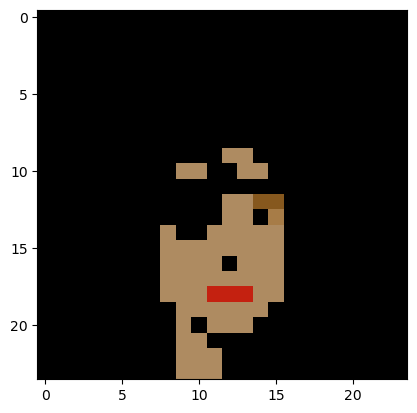

In [14]:
plt.imshow(X_test[pid])